In [1]:
import copy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm

In [2]:
X_original = pd.read_csv('./data/preprocessing/X_fill.csv')
y = pd.read_csv('./data/preprocessing/y.csv')

In [3]:
top_feature_choice = [
    "wrkstat_Working fulltime",
    "polviews_Conservative",
    "educ_center",
    "polviews_Slightly liberal",
    "polviews_Moderate",
    "polviews_unknown"
]

X = X_original[top_feature_choice]

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wrkstat_Working fulltime   1649 non-null   int64  
 1   polviews_Conservative      1649 non-null   int64  
 2   educ_center                1649 non-null   float64
 3   polviews_Slightly liberal  1649 non-null   int64  
 4   polviews_Moderate          1649 non-null   int64  
 5   polviews_unknown           1649 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 77.4 KB


array([[<Axes: title={'center': 'email_time_center'}>]], dtype=object)

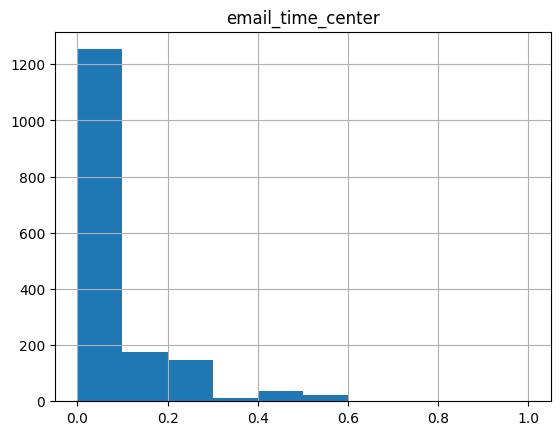

In [5]:
y.hist()

In [6]:
def interval_class(num):
  if num < 0.1:
    return 0
  if 0.1 <= num < 0.2:
    return 1
  if 0.2 <= num < 0.4:
    return 2
  if num >= 0.4:
    return 3

In [7]:
y['label'] = y['email_time_center'].apply(lambda num : interval_class(num))

In [8]:
y.to_csv('./data/preprocessing/y_label.csv', index=False)

In [9]:
y.head()

,email_time_center,label
0,0.120000,1
1,0.005000,0
2,0.001667,0
3,0.020000,0
4,0.400000,3


array([[<Axes: title={'center': 'email_time_center'}>,
        <Axes: title={'center': 'label'}>]], dtype=object)

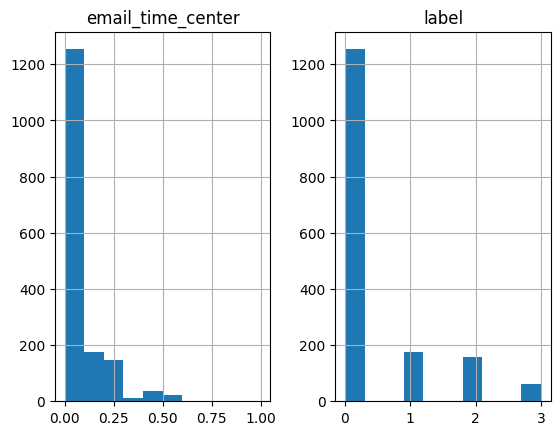

In [10]:
y.hist()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [12]:
y_train.groupby(['label']).count() / y_train.shape[0]

,email_time_center
label,
0,0.770281
1,0.104625
2,0.091736
3,0.033359


In [13]:
class_weight = {
  0: 0.770281,
  1: 0.104625,
  2: 0.091736, 
  3: 0.033359
}

wclf = svm.SVC(kernel='linear', class_weight=class_weight)
wclf.fit(X_train, y_train['label'])

clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train['label'])

SVC(class_weight='balanced', kernel='linear')

In [14]:
# model = svm.SVC(gamma='scale')
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_train, y_train['label'], scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % np.mean(scores))

In [15]:
print(f'with class weight: {wclf.score(X_test, y_test["label"])}')
print(f'without class weight: {clf.score(X_test, y_test["label"])}')

with class weight: 0.7181818181818181
without class weight: 0.45151515151515154


In [16]:
from sklearn.preprocessing import LabelBinarizer

# y = y['label']
# y = y.reshape(-1, 1)

y = LabelBinarizer().fit_transform(y['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(in_features=6, out_features=64)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=64, out_features=128)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(128, 4)
        
    def forward(self, X_):
        X_ = self.linear_1(X_)
        X_ = self.relu(X_)
        X_ = self.linear_2(X_)
        X_ = self.tanh(X_)
        return self.output(X_)
    

cuda


In [18]:
model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# training parameters
n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch
batches_per_epoch = len(X_train) // batch_size
batch_start = torch.arange(0, len(X_train), batch_size)

In [20]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [21]:
y_train.shape

torch.Size([1319, 4])

In [22]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    # correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    # acc = (correct / len(y_pred)) * 100 
    # return acc
    return (torch.argmax(y_pred, 1) == torch.argmax(y_true, 1)).float().mean()
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_logits = model.forward(X_batch).squeeze()
            y_out = torch.sigmoid(y_logits)
            loss = loss_fn(y_out, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = accuracy_fn(y_true=y_batch, y_pred=y_out) 
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    # y_pred = model(X_test)
    y_pred = torch.sigmoid(model.forward(X_test).squeeze())
    ce = loss_fn(y_pred, y_test)
    # acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    acc = accuracy_fn(y_true=y_test, y_pred=y_pred) 
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

Epoch 0: 100%|██████████| 131/131 [00:00<00:00, 200.48batch/s, acc=0.9, loss=0.848]


Epoch 0 validation: Cross-entropy=1.027794599533081, Accuracy=0.7181817889213562


Epoch 1: 100%|██████████| 131/131 [00:00<00:00, 871.96batch/s, acc=0.9, loss=0.845] 


Epoch 1 validation: Cross-entropy=1.026084303855896, Accuracy=0.7181817889213562


Epoch 2: 100%|██████████| 131/131 [00:00<00:00, 706.34batch/s, acc=0.9, loss=0.844] 


Epoch 2 validation: Cross-entropy=1.025753140449524, Accuracy=0.7181817889213562


Epoch 3: 100%|██████████| 131/131 [00:00<00:00, 881.60batch/s, acc=0.9, loss=0.844] 


Epoch 3 validation: Cross-entropy=1.0256377458572388, Accuracy=0.7181817889213562


Epoch 4: 100%|██████████| 131/131 [00:00<00:00, 949.93batch/s, acc=0.9, loss=0.844] 


Epoch 4 validation: Cross-entropy=1.0255844593048096, Accuracy=0.7181817889213562


Epoch 5: 100%|██████████| 131/131 [00:00<00:00, 811.84batch/s, acc=0.9, loss=0.844] 


Epoch 5 validation: Cross-entropy=1.0255552530288696, Accuracy=0.7181817889213562


Epoch 6: 100%|██████████| 131/131 [00:00<00:00, 661.07batch/s, acc=0.9, loss=0.844]


Epoch 6 validation: Cross-entropy=1.0255377292633057, Accuracy=0.7181817889213562


Epoch 7: 100%|██████████| 131/131 [00:00<00:00, 635.98batch/s, acc=0.9, loss=0.844]


Epoch 7 validation: Cross-entropy=1.0255264043807983, Accuracy=0.7181817889213562


Epoch 8: 100%|██████████| 131/131 [00:00<00:00, 797.32batch/s, acc=0.9, loss=0.844] 


Epoch 8 validation: Cross-entropy=1.025518536567688, Accuracy=0.7181817889213562


Epoch 9: 100%|██████████| 131/131 [00:00<00:00, 822.11batch/s, acc=0.9, loss=0.844] 


Epoch 9 validation: Cross-entropy=1.0255126953125, Accuracy=0.7181817889213562


Epoch 10: 100%|██████████| 131/131 [00:00<00:00, 868.10batch/s, acc=0.9, loss=0.844]


Epoch 10 validation: Cross-entropy=1.0255084037780762, Accuracy=0.7181817889213562


Epoch 11:  23%|██▎       | 30/131 [00:00<00:00, 835.24batch/s, acc=0.8, loss=0.944]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 20: 100%|██████████| 131/131 [00:00<00:00, 833.30batch/s, acc=0.9, loss=0.844]


Epoch 20 validation: Cross-entropy=1.0254926681518555, Accuracy=0.7181817889213562


Epoch 21: 100%|██████████| 131/131 [00:00<00:00, 922.42batch/s, acc=0.9, loss=0.844] 


Epoch 21 validation: Cross-entropy=1.0254921913146973, Accuracy=0.7181817889213562


Epoch 22: 100%|██████████| 131/131 [00:00<00:00, 915.84batch/s, acc=0.9, loss=0.844] 


Epoch 22 validation: Cross-entropy=1.025491714477539, Accuracy=0.7181817889213562


Epoch 23: 100%|██████████| 131/131 [00:00<00:00, 846.78batch/s, acc=0.9, loss=0.844] 


Epoch 23 validation: Cross-entropy=1.0254913568496704, Accuracy=0.7181817889213562


Epoch 24: 100%|██████████| 131/131 [00:00<00:00, 853.93batch/s, acc=0.9, loss=0.844] 


Epoch 24 validation: Cross-entropy=1.0254908800125122, Accuracy=0.7181817889213562


Epoch 25: 100%|██████████| 131/131 [00:00<00:00, 845.99batch/s, acc=0.9, loss=0.844] 


Epoch 25 validation: Cross-entropy=1.0254905223846436, Accuracy=0.7181817889213562


Epoch 26: 100%|██████████| 131/131 [00:00<00:00, 842.51batch/s, acc=0.9, loss=0.844] 


Epoch 26 validation: Cross-entropy=1.025490164756775, Accuracy=0.7181817889213562


Epoch 27: 100%|██████████| 131/131 [00:00<00:00, 876.39batch/s, acc=0.9, loss=0.844]


Epoch 27 validation: Cross-entropy=1.0254899263381958, Accuracy=0.7181817889213562


Epoch 28: 100%|██████████| 131/131 [00:00<00:00, 841.22batch/s, acc=0.9, loss=0.844] 


Epoch 28 validation: Cross-entropy=1.0254895687103271, Accuracy=0.7181817889213562


Epoch 29: 100%|██████████| 131/131 [00:00<00:00, 890.18batch/s, acc=0.9, loss=0.844] 


Epoch 29 validation: Cross-entropy=1.025489330291748, Accuracy=0.7181817889213562


Epoch 30: 100%|██████████| 131/131 [00:00<00:00, 935.81batch/s, acc=0.9, loss=0.844] 


Epoch 30 validation: Cross-entropy=1.0254892110824585, Accuracy=0.7181817889213562


Epoch 31:  57%|█████▋    | 75/131 [00:00<00:00, 837.89batch/s, acc=0.8, loss=0.944] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 42: 100%|██████████| 131/131 [00:00<00:00, 945.35batch/s, acc=0.9, loss=0.844] 


Epoch 42 validation: Cross-entropy=1.0254876613616943, Accuracy=0.7181817889213562


Epoch 43: 100%|██████████| 131/131 [00:00<00:00, 837.26batch/s, acc=0.9, loss=0.844] 


Epoch 43 validation: Cross-entropy=1.0254875421524048, Accuracy=0.7181817889213562


Epoch 44: 100%|██████████| 131/131 [00:00<00:00, 533.84batch/s, acc=0.9, loss=0.844]


Epoch 44 validation: Cross-entropy=1.0254875421524048, Accuracy=0.7181817889213562


Epoch 45: 100%|██████████| 131/131 [00:00<00:00, 843.41batch/s, acc=0.9, loss=0.844] 


Epoch 45 validation: Cross-entropy=1.0254875421524048, Accuracy=0.7181817889213562


Epoch 46: 100%|██████████| 131/131 [00:00<00:00, 850.46batch/s, acc=0.9, loss=0.844] 


Epoch 46 validation: Cross-entropy=1.0254874229431152, Accuracy=0.7181817889213562


Epoch 47: 100%|██████████| 131/131 [00:00<00:00, 813.80batch/s, acc=0.9, loss=0.844]


Epoch 47 validation: Cross-entropy=1.0254873037338257, Accuracy=0.7181817889213562


Epoch 48: 100%|██████████| 131/131 [00:00<00:00, 877.29batch/s, acc=0.9, loss=0.844]


Epoch 48 validation: Cross-entropy=1.0254871845245361, Accuracy=0.7181817889213562


Epoch 49: 100%|██████████| 131/131 [00:00<00:00, 839.46batch/s, acc=0.9, loss=0.844] 


Epoch 49 validation: Cross-entropy=1.0254871845245361, Accuracy=0.7181817889213562


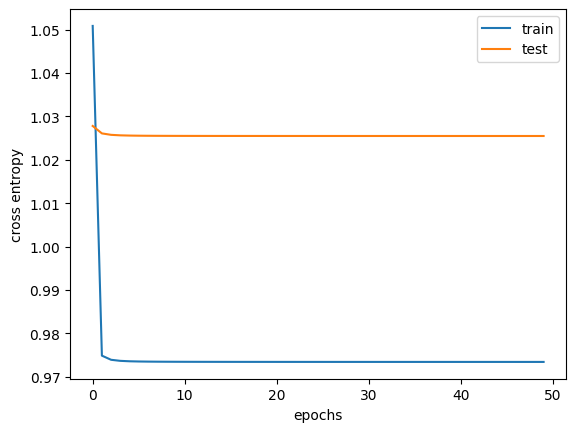

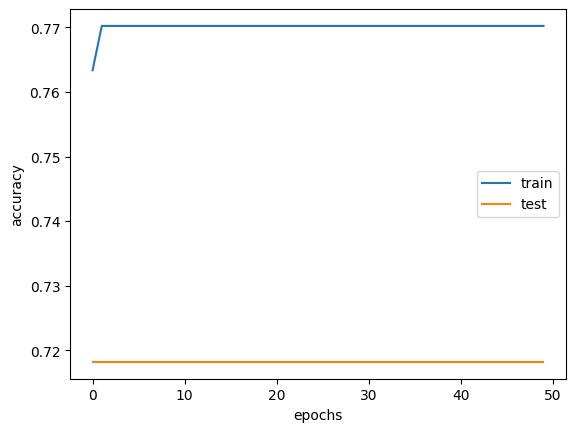

In [23]:
# Restore best model
model.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [24]:
from torcheval.metrics.functional import multiclass_f1_score

In [28]:
y_pred = torch.argmax(torch.sigmoid(model.forward(X_test).squeeze()), 1)
y_test_one = torch.argmax(y_test, 1)
multiclass_f1_score(y_pred, y_test_one, num_classes=4)

tensor(0.7182, device='cuda:0')